## VGG16 Model for CIFAR10 Dataset

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

class cifar10vgg:
    def __init__(self,train=False):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
#         if train:
#             self.model = self.train(self.model)
#         else:
#             self.model.load_weights('cifar10vgg.h5')


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):

        #training parameters
        batch_size = 128
        maxepoches = 250
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
        filepath = './model-{epoch:03d}.h5'
        call = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        #data augmentation
        #datagen = ImageDataGenerator(
        #    featurewise_center=False,  # set input mean to 0 over the dataset
        #    samplewise_center=False,  # set each sample mean to 0
        #    featurewise_std_normalization=False,  # divide inputs by std of the dataset
        #    samplewise_std_normalization=False,  # divide each input by its std
        #    zca_whitening=False,  # apply ZCA whitening
        #    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        #    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #    horizontal_flip=True,  # randomly flip images
        #    vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        #datagen.fit(x_train)
        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
        # training process in a for loop with learning rate drop every 25 epoches.
        historytemp = model.fit(x_train, y_train,
                                         batch_size = batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr,call])
        model.save_weights('cifar10vgg.h5')
        return model

if __name__ == '__main__':


    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    model = cifar10vgg()

#     predicted_x = model.predict(x_test)
#     residuals = np.argmax(predicted_x,1)!=np.argmax(y_test,1)

#     loss = sum(residuals)/len(residuals)
#     print("the validation 0/1 loss is: ",loss)



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir("/content/gdrive/My Drive/Final_Folder")

## Loading the pre trained weights

In [0]:
model.model.load_weights("./Weights/cifar10vgg.h5")

In [0]:
mapper = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

## Testing on Normal Images

In [0]:
list_images = np.load("./Test_Data/CIFAR10/listOfImagesCIFAR.npy")

In [0]:
import matplotlib.pyplot as plt

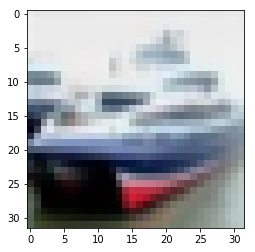

In [8]:
plt.imshow(x_test[1]/255)

In [9]:
op = model.predict(x_test[1].reshape(1, 32, 32, 3))
print(op)
print("Prediction:",mapper[np.argmax(op)])
print("Expected:",mapper[np.argmax(y_test[1])])

[[3.7644470e-05 2.1951283e-04 4.4118401e-06 1.8643255e-05 1.3935556e-06
  1.8353398e-05 3.6485105e-06 3.4358070e-06 9.9967778e-01 1.5282631e-05]]
Prediction: ship
Expected: ship


## Testing on Rotated Images

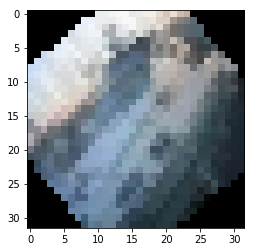

In [10]:
i = 2
plt.imshow(list_images[i])

In [11]:
op = model.predict(list_images[i].reshape(1, 32, 32, 3))
print(op)
print("Prediction:",mapper[np.argmax(op)])
print("Expected:",mapper[np.argmax(y_test[i])])

[[2.1595770e-02 5.5363894e-01 4.0557894e-01 8.9391746e-04 4.1867046e-05
  3.2953700e-04 2.0788156e-03 2.0039428e-03 1.3232364e-02 6.0590293e-04]]
Prediction: automobile
Expected: ship


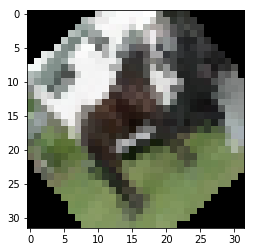

In [12]:
i = 20
plt.imshow(list_images[i])

In [13]:
op = model.predict(list_images[i].reshape(1, 32, 32, 3))
print(op)
print("Prediction:",mapper[np.argmax(op)])
print("Expected:",mapper[np.argmax(y_test[i])])

[[1.17783491e-02 2.13447511e-02 7.51151919e-01 1.36917736e-03
  1.18614706e-04 2.23571225e-03 6.85656269e-04 2.09396094e-01
  4.55384616e-05 1.87413872e-03]]
Prediction: bird
Expected: horse


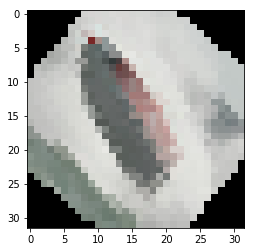

In [14]:
i = 1294
plt.imshow(list_images[i])

In [15]:
op = model.predict(list_images[i].reshape(1, 32, 32, 3))
print("Prediction:",mapper[np.argmax(op)])
print("Expected:",mapper[np.argmax(y_test[i])])

Prediction: bird
Expected: ship


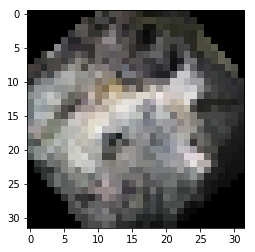

In [16]:
i = 5141
plt.imshow(list_images[i])

In [17]:
op = model.predict(list_images[i].reshape(1, 32, 32, 3))
print("Prediction:",mapper[np.argmax(op)])
print("Expected:",mapper[np.argmax(y_test[i])])

Prediction: cat
Expected: frog


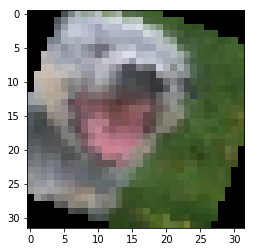

In [18]:
i = 9557
plt.imshow(list_images[i])

In [19]:
op = model.predict(list_images[i].reshape(1, 32, 32, 3))
print("Prediction:",mapper[np.argmax(op)])
print("Expected:",mapper[np.argmax(y_test[i])])

Prediction: bird
Expected: dog
